In [1]:
from corpustool.models import *

In [2]:
from django.db.models import *

Оценим объём текстов респондентов каждого пола:

In [3]:
Document.objects.all().aggregate(django.db.models.Count('sex'))

{'sex__count': 4700}

In [5]:
len(Document.objects.filter(sex='f'))

3216

In [6]:
len(Document.objects.filter(sex='m'))

1484

Посмотрим, как распределены оценки

In [4]:
import pandas as pd

In [4]:
import scipy.stats

In [13]:
all_marks = pd.Series(i.mark for i in Document.objects.all())

In [16]:
all_marks.describe()

count    2985.000000
mean       53.122278
std        18.520443
min         1.000000
25%        55.000000
50%        60.000000
75%        65.000000
max        85.000000
dtype: float64

In [51]:
x, y = [], []
i = 0
while i <= 1.0:
    x.append(i)
    y.append(all_marks.quantile(i))
    i += 0.01

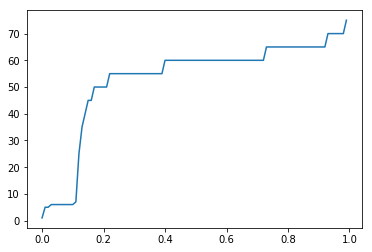

In [53]:
plt.figure()
plt.plot(x, y)
plt.show()

In [17]:
import matplotlib.pyplot as plt

In [37]:
all_marks.quantile(0.1)

6.0

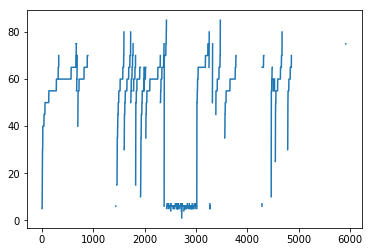

In [39]:
plt.figure(1)
plt.plot(sorted(all_marks))
plt.sh

In [21]:
help(plt.boxplot)

Help on function boxplot in module matplotlib.pyplot:

boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_xticks=True, autorange=False, zorder=None, *, data=None)
    Make a box and whisker plot.
    
    Make a box and whisker plot for each column of ``x`` or each
    vector in sequence ``x``.  The box extends from the lower to
    upper quartile values of the data, with a line at the median.
    The whiskers extend from the box to show the range of the
    data.  Flier points are those past the end of the whiskers.
    
    Parameters
    ----------
    x : Array or a sequence of vectors.
        The input data.
    
    notch : bool, optional (False)
        If `True`, will produce a 

{'whiskers': [<matplotlib.lines.Line2D at 0x1ee13ab4e10>,
 'caps': [<matplotlib.lines.Line2D at 0x1ee13ab4dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ee13ab4a20>],
 'medians': [<matplotlib.lines.Line2D at 0x1ee13abfb70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ee13abfeb8>],
 'means': []}

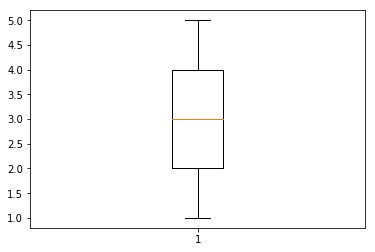

In [26]:
plt.boxplot([1,2,3,4,5])

Выделим ключевые слова по t-score для М и Ж корпусов:

In [5]:
m_texts = Document.objects.filter(sex='m')
f_texts = Document.objects.filter(sex='f')

Возьмём 75%-ю квантиль токенов по употреблениям (т.е. те, которые встречаются не реже 4 раз
см. таблицу ниже):

In [19]:
pd.DataFrame(Token.objects.all().annotate(count = Count('occurence__document')).values('count')).describe()

,count
count,34315.000000
mean,47.132857
std,891.721763
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,74424.000000


In [18]:
pd.DataFrame(Token.objects.all().annotate(count = Count('occurence')).values('count')).describe()

,count
count,34315.000000
mean,47.132857
std,891.721763
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,74424.000000


In [7]:
tokens = Token.objects.annotate(count = Count('occurence__document')).filter(count__gte=4)

На обработку этих токенов потребуется 1.072 часа:

In [35]:
(len(tokens) * 0.37) / 3600

1.0171916666666667

In [8]:
import time

In [74]:
time.time()

1557536638.9984145

In [ ]:
for token in tokens:
    t = time.time()
    m_texts_avg = m_texts.annotate(token_count=Count('occurence',
                                                     filter=Q(occurence__token=token))).aggregate(m_avg=Avg('token_count'))['m_avg']
    f_texts_avg = f_texts.annotate(token_count=Count('occurence',
                                                     filter=Q(occurence__token=token))).aggregate(f_avg=Avg('token_count'))['f_avg']
    token.m_avg = m_texts_avg
    token.f_avg = f_texts_avg

Попробуем встроенными средствами scipy:

In [9]:
all_texts = Document.objects.all()

In [26]:
df=pd.DataFrame(columns=('a','b','c'))
df=df.append({'a':0,'b':1,'c':2},ignore_index=True)
df

,a,b,c
0,0,1,2


In [43]:
keywords = pd.DataFrame(columns=('token','lemma','POS',
                                 'frequency(M)', 'frequency(F)',
                                 'Mean frequency(M)', 'Mean frequency(F)',
                                 'Chi2','p-value(Chi2)',
                          'LL','p-value(LL)',"Welch's t","p-value(Welch's t)"))
for token in tokens:
    #t = time.time()
    m_count = pd.DataFrame(m_texts.annotate(pos=Count('occurence', filter=Q(occurence__token=token)),
                                  neg=Count('occurence', exclude=Q(occurence__token=token))).values('pos', 'neg'))
    f_count = pd.DataFrame(f_texts.annotate(pos=Count('occurence', filter=Q(occurence__token=token)),
                                  neg=Count('occurence', exclude=Q(occurence__token=token))).values('pos', 'neg'))
    cont_table = ((m_count['pos'].sum(),f_count['pos'].sum()),
                  (m_count['neg'].sum(),f_count['neg'].sum()))
    if sum(cont_table[0]):
        ## Chi2 and log-likelihood tests:
        chi2_res=scipy.stats.chi2_contingency(cont_table)
        ll_res=scipy.stats.chi2_contingency(cont_table,lambda_="log-likelihood")
        ## Welch's t-test:
        t_res = scipy.stats.ttest_ind(m_count['pos'],f_count['pos'])

        keywords = keywords.append({'token':token.text, 'lemma':token.lemma.text, 'POS':token.lemma.pos,
                    'frequency(M)': cont_table[0][0], 'frequency(F)': cont_table[0][1],
                    'Mean frequency(M)': m_count['pos'].mean(), 'Mean frequency(F)': f_count['pos'].mean(),
                    'Chi2':chi2_res[0],'p-value(Chi2)':chi2_res[1],
                    'LL':ll_res[0],'p-value(LL)':ll_res[1],
                    "Welch's t":t_res.statistic,"p-value(Welch's t)":t_res.pvalue}, ignore_index=True)
        #print(time.time() - t)

In [10]:
df = pd.DataFrame([{'a':0,'b':1,'c':2,'d':3},
                  {'a':-4,'b':7,'c':9,'d':-1},
                  {'a':2,'b':-2,'c':3,'d':4},
                  {'a':-1,'b':-7,'c':-6,'d':11}])

In [19]:
res = scipy.stats.ttest_ind(df['b'],df['a'])
print(res.statistic, res.pvalue)

0.15713484026367722 0.8802929851488207


In [56]:
help(django.db.models.Q)

Help on class Q in module django.db.models.query_utils:

class Q(django.utils.tree.Node)
 |  Q(*args, _connector=None, _negated=False, **kwargs)
 |  
 |  Encapsulate filters as objects that can then be combined logically (using
 |  `&` and `|`).
 |  
 |  Method resolution order:
 |      Q
 |      django.utils.tree.Node
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __and__(self, other)
 |  
 |  __init__(self, *args, _connector=None, _negated=False, **kwargs)
 |      Construct a new Node. If no connector is given, use the default.
 |  
 |  __invert__(self)
 |  
 |  __or__(self, other)
 |  
 |  deconstruct(self)
 |  
 |  resolve_expression(self, query=None, allow_joins=True, reuse=None, summarize=False, for_save=False)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  AND = 'AND'
 |  
 |  OR = 'OR'
 |  
 |  conditional = True
 |  
 |  default = 'AND'
 |  
 |  ------------------------------

In [22]:
tokens[0]

<Token: Token object (36867)>

In [44]:
keywords

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
0,it,-pron-,PRON,4576,10611,3.083558,3.299440,7.418330,6.456270e-03,7.462981,6.298064e-03,-2.707367,6.806458e-03
1,us,-pron-,PRON,372,554,0.250674,0.172264,34.580493,4.089843e-09,33.083835,8.826955e-09,4.365070,1.298122e-05
2,they,-pron-,PRON,1492,3468,1.005391,1.078358,2.654039,1.032871e-01,2.670984,1.021928e-01,-1.365386,1.721970e-01
3,you,-pron-,PRON,493,948,0.332210,0.294776,6.091616,1.358248e-02,5.991227,1.437720e-02,0.930568,3.521251e-01
4,i,-pron-,PRON,1471,2974,0.991240,0.924751,7.591743,5.863622e-03,7.510641,6.133556e-03,1.357939,1.745484e-01
5,we,-pron-,PRON,1706,2744,1.149596,0.853234,105.949604,7.563444e-25,102.169887,5.095868e-24,5.665537,1.553074e-08
6,ourselves,-pron-,PRON,6,29,0.004043,0.009017,2.587229,1.077286e-01,2.846689,9.156233e-02,-1.793065,7.302681e-02
7,them,-pron-,PRON,724,1501,0.487871,0.466729,1.893718,1.687832e-01,1.879218,1.704231e-01,0.766087,4.436633e-01
8,he,-pron-,PRON,259,563,0.174528,0.175062,0.030740,8.608221e-01,0.030689,8.609355e-01,-0.026446,9.789029e-01
9,she,-pron-,PRON,78,189,0.052561,0.058769,0.386999,5.338813e-01,0.391152,5.316944e-01,-0.570041,5.686771e-01


In [45]:
keywords.describe()

,Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
count,8866.000000,8866.000000,8.866000e+03,8.866000e+03,8.866000e+03,8.866000e+03,8866.000000,8.866000e+03
mean,0.028081,0.028709,1.886382e+00,5.236386e-01,1.907455e+00,5.217719e-01,0.088961,4.246343e-01
std,0.272209,0.283562,6.746275e+00,3.146418e-01,7.104952e+00,3.154856e-01,1.247325,2.915464e-01
min,0.000000,0.000000,5.792955e-11,1.534313e-46,9.653755e-11,4.768143e-47,-6.813853,1.070084e-11
25%,0.000674,0.000622,7.217128e-02,2.272652e-01,7.081836e-02,2.155228e-01,-0.786006,1.713227e-01
50%,0.002022,0.001866,2.939317e-01,5.877120e-01,3.297696e-01,5.657948e-01,0.055798,4.050243e-01
75%,0.007412,0.007152,1.457896e+00,7.882012e-01,1.533935e+00,7.901489e-01,0.909479,6.527355e-01
max,11.776280,11.986940,2.051965e+02,9.999939e-01,2.075227e+02,9.999922e-01,5.665537,9.997374e-01


In [46]:
keywords.to_csv('MvsFkeywords.csv')

In [4]:
keywords1 = pd.read_csv('MvsFkeywords.csv', index_col='Unnamed: 0')

In [5]:
keywords1.describe()

,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
count,8866.000000,8866.000000,8866.000000,8866.000000,8.866000e+03,8.866000e+03,8.866000e+03,8.866000e+03,8866.000000,8.866000e+03
mean,41.671554,92.326641,0.028081,0.028709,1.886382e+00,5.236386e-01,1.907455e+00,5.217719e-01,0.088961,4.246343e-01
std,403.958358,911.934454,0.272209,0.283562,6.746275e+00,3.146418e-01,7.104952e+00,3.154856e-01,1.247325,2.915464e-01
min,0.000000,0.000000,0.000000,0.000000,5.792955e-11,1.534313e-46,9.653755e-11,4.768143e-47,-6.813853,1.070084e-11
25%,1.000000,2.000000,0.000674,0.000622,7.217128e-02,2.272652e-01,7.081836e-02,2.155228e-01,-0.786006,1.713227e-01
50%,3.000000,6.000000,0.002022,0.001866,2.939317e-01,5.877120e-01,3.297696e-01,5.657948e-01,0.055798,4.050243e-01
75%,11.000000,23.000000,0.007412,0.007152,1.457896e+00,7.882012e-01,1.533935e+00,7.901489e-01,0.909479,6.527355e-01
max,17476.000000,38550.000000,11.776280,11.986940,2.051965e+02,9.999939e-01,2.075227e+02,9.999922e-01,5.665537,9.997374e-01


Посмотри на ключевые слова для женского подкорпуса по Welch's t:

In [9]:
keywords1.sort_values(by="Welch's t").head(n=20)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
1178,developing,develop,VERB,213,1155,0.143531,0.359142,154.219918,2.073330e-35,175.017901,5.933318e-40,-6.813853,1.070084e-11
101,the,the,DET,15970,38550,10.761456,11.986940,85.281966,2.587121e-20,86.175445,1.646596e-20,-6.516256,7.965082e-11
405,contrast,contrast,NOUN,55,278,0.037062,0.086443,32.619456,1.120871e-08,36.595150,1.453930e-09,-5.757448,9.082714e-09
713,moreover,moreover,ADV,285,874,0.192049,0.271766,23.024972,1.599107e-06,24.046730,9.402580e-07,-5.238495,1.689691e-07
4810,\n\n,\n\n,SPACE,582,1884,0.392183,0.585821,65.289783,6.465568e-16,68.714245,1.138158e-16,-5.224963,1.817277e-07
3094,2011,2011,NUM,60,412,0.040431,0.128109,74.039158,7.658269e-18,86.926351,1.126385e-20,-5.218235,1.884129e-07
2064,overall,overall,PROPN,50,227,0.033693,0.070585,21.594623,3.367947e-06,23.839420,1.047158e-06,-5.004007,5.820108e-07
617,illustrate,illustrate,VERB,31,168,0.020889,0.052239,21.812460,3.006414e-06,24.696129,6.711883e-07,-4.973002,6.827344e-07
1179,developed,develop,VERB,165,719,0.111186,0.223570,63.760576,1.404972e-15,70.045807,5.794318e-17,-4.869578,1.155082e-06
1521,workers,worker,NOUN,46,318,0.030997,0.098881,57.369889,3.610934e-14,67.394711,2.222443e-16,-4.838186,1.352235e-06


Для мужского подкорпуса по Welch's t:

In [10]:
keywords1.sort_values(by="Welch's t", ascending=False).head(n=20)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
5,we,-pron-,PRON,1706,2744,1.149596,0.853234,105.949604,7.563444e-25,102.169887,5.095868e-24,5.665537,1.553074e-08
2182,eats,eat,VERB,20,3,0.013477,0.000933,30.822340,2.827638e-08,28.466238,9.534673e-08,5.299646,1.213373e-07
2024,social,social,ADJ,557,698,0.375337,0.217040,101.469279,7.258039e-24,95.545526,1.445291e-22,5.127665,3.051466e-07
6899,calls,call,NOUN,105,6,0.070755,0.001866,205.196481,1.534313e-46,199.005914,3.441647e-45,4.994536,6.111510e-07
2980,yakutsk,yakutsk,PROPN,171,116,0.115229,0.036070,106.681079,5.228953e-25,96.913052,7.243959e-23,4.939665,8.097329e-07
3034,import,import,NOUN,86,36,0.057951,0.011194,86.120576,1.692922e-20,77.740092,1.175313e-18,4.921412,8.886169e-07
4561,unpaid,unpaid,ADJ,28,1,0.018868,0.000311,54.787537,1.342897e-13,53.436736,2.670559e-13,4.828180,1.421617e-06
1793,service,service,NOUN,46,20,0.030997,0.006219,43.897808,3.459762e-11,39.620273,3.084645e-10,4.667408,3.135118e-06
2981,rio,rio,PROPN,162,119,0.109164,0.037002,90.634690,1.728040e-21,82.569727,1.020075e-19,4.633835,3.686678e-06
439,content,content,NOUN,127,92,0.085580,0.028607,72.204086,1.940535e-17,65.747866,5.124602e-16,4.594606,4.449204e-06


В целом, ключевые для гендера слова по Welch's t:

In [12]:
keywords1.sort_values(by="p-value(Welch's t)").head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
1178,developing,develop,VERB,213,1155,0.143531,0.359142,154.219918,2.073330e-35,175.017901,5.933318e-40,-6.813853,1.070084e-11
101,the,the,DET,15970,38550,10.761456,11.986940,85.281966,2.587121e-20,86.175445,1.646596e-20,-6.516256,7.965082e-11
405,contrast,contrast,NOUN,55,278,0.037062,0.086443,32.619456,1.120871e-08,36.595150,1.453930e-09,-5.757448,9.082714e-09
5,we,-pron-,PRON,1706,2744,1.149596,0.853234,105.949604,7.563444e-25,102.169887,5.095868e-24,5.665537,1.553074e-08
2182,eats,eat,VERB,20,3,0.013477,0.000933,30.822340,2.827638e-08,28.466238,9.534673e-08,5.299646,1.213373e-07
713,moreover,moreover,ADV,285,874,0.192049,0.271766,23.024972,1.599107e-06,24.046730,9.402580e-07,-5.238495,1.689691e-07
4810,\n\n,\n\n,SPACE,582,1884,0.392183,0.585821,65.289783,6.465568e-16,68.714245,1.138158e-16,-5.224963,1.817277e-07
3094,2011,2011,NUM,60,412,0.040431,0.128109,74.039158,7.658269e-18,86.926351,1.126385e-20,-5.218235,1.884129e-07
2024,social,social,ADJ,557,698,0.375337,0.217040,101.469279,7.258039e-24,95.545526,1.445291e-22,5.127665,3.051466e-07
2064,overall,overall,PROPN,50,227,0.033693,0.070585,21.594623,3.367947e-06,23.839420,1.047158e-06,-5.004007,5.820108e-07


И совсем не ключевые слова:

In [13]:
keywords1.sort_values(by="p-value(Welch's t)", ascending=False).head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
2798,probability,probability,NOUN,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000329,0.999737
676,creations,creation,NOUN,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000340,0.999728
7678,countryside,countryside,NOUN,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000340,0.999728
8715,lighting,lighting,NOUN,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000367,0.999707
2163,attracts,attract,VERB,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000382,0.999695
6092,polluting,pollute,VERB,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000400,0.999681
4740,advertisement,advertisement,NOUN,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000400,0.999681
1559,feels,feel,VERB,6,13,0.004043,0.004042,4.353128e-02,0.834728,4.412488e-02,0.833621,0.000421,0.999664
735,cinemas,cinema,NOUN,12,26,0.008086,0.008085,1.438592e-02,0.904530,1.446333e-02,0.904274,0.000482,0.999615
1454,assume,assume,VERB,12,26,0.008086,0.008085,1.438592e-02,0.904530,1.446333e-02,0.904274,0.000554,0.999558


Ключевые для гендера слова по Chi2:

In [14]:
keywords1.sort_values(by="Chi2", ascending=False).head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
6899,calls,call,NOUN,105,6,0.070755,0.001866,205.196481,1.534313e-46,199.005914,3.441647e-45,4.994536,6.111510e-07
1178,developing,develop,VERB,213,1155,0.143531,0.359142,154.219918,2.073330e-35,175.017901,5.933318e-40,-6.813853,1.070084e-11
4964,,,SPACE,15,408,0.010108,0.126866,149.092343,2.737511e-34,207.522737,4.768143e-47,-3.987028,6.792209e-05
2977,temperature,temperature,NOUN,231,167,0.155660,0.051928,132.695486,1.053998e-30,120.808525,4.208525e-28,4.443891,9.037985e-06
1371,investment,investment,NOUN,100,674,0.067385,0.209577,119.194961,9.492578e-28,139.632420,3.203286e-32,-4.624536,3.855200e-06
2980,yakutsk,yakutsk,PROPN,171,116,0.115229,0.036070,106.681079,5.228953e-25,96.913052,7.243959e-23,4.939665,8.097329e-07
5,we,-pron-,PRON,1706,2744,1.149596,0.853234,105.949604,7.563444e-25,102.169887,5.095868e-24,5.665537,1.553074e-08
4494,minutes,minute,NOUN,238,203,0.160377,0.063122,105.787542,8.208000e-25,97.023276,6.851713e-23,4.095615,4.281330e-05
7145,$,$,SYM,52,457,0.035040,0.142102,103.119362,3.155520e-24,125.423009,4.112396e-29,-3.992584,6.635497e-05
2024,social,social,ADJ,557,698,0.375337,0.217040,101.469279,7.258039e-24,95.545526,1.445291e-22,5.127665,3.051466e-07


И совсем не ключевые:

In [15]:
keywords1.sort_values(by="Chi2").head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
548,normal,normal,ADJ,46,100,0.030997,0.031095,5.792955e-11,0.999994,9.653755e-11,0.999992,-0.015593,0.987560
3659,experiences,experience,NOUN,22,47,0.014825,0.014614,7.830109e-07,0.999294,7.829692e-07,0.999294,0.038029,0.969667
2602,encourage,encourage,VERB,22,47,0.014825,0.014614,7.830109e-07,0.999294,7.829692e-07,0.999294,0.048437,0.961370
1593,end,end,NOUN,65,142,0.043801,0.044154,2.348765e-06,0.998777,2.349005e-06,0.998777,-0.046176,0.963172
1051,old,old,ADJ,308,682,0.207547,0.212065,3.251654e-06,0.998561,3.251822e-06,0.998561,-0.179208,0.857782
569,pirate,pirate,NOUN,108,237,0.072776,0.073694,3.914161e-06,0.998421,3.914192e-06,0.998421,-0.061635,0.950856
467,really,really,ADV,214,471,0.144205,0.146455,3.974053e-06,0.998409,3.973833e-06,0.998409,-0.145756,0.884120
1104,populations,population,NOUN,40,90,0.026954,0.027985,6.585988e-06,0.997952,6.586597e-06,0.997952,-0.163178,0.870386
192,having,have,VERB,83,185,0.055930,0.057525,7.129608e-06,0.997870,7.129793e-06,0.997870,-0.173593,0.862193
3133,professional,professional,ADJ,59,132,0.039757,0.041045,1.377462e-05,0.997039,1.377570e-05,0.997039,-0.134470,0.893037


Ключевые для гендера слова по LL:

In [16]:
keywords1.sort_values(by="LL", ascending=False).head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
4964,,,SPACE,15,408,0.010108,0.126866,149.092343,2.737511e-34,207.522737,4.768143e-47,-3.987028,6.792209e-05
6899,calls,call,NOUN,105,6,0.070755,0.001866,205.196481,1.534313e-46,199.005914,3.441647e-45,4.994536,6.111510e-07
1178,developing,develop,VERB,213,1155,0.143531,0.359142,154.219918,2.073330e-35,175.017901,5.933318e-40,-6.813853,1.070084e-11
1371,investment,investment,NOUN,100,674,0.067385,0.209577,119.194961,9.492578e-28,139.632420,3.203286e-32,-4.624536,3.855200e-06
7145,$,$,SYM,52,457,0.035040,0.142102,103.119362,3.155520e-24,125.423009,4.112396e-29,-3.992584,6.635497e-05
2977,temperature,temperature,NOUN,231,167,0.155660,0.051928,132.695486,1.053998e-30,120.808525,4.208525e-28,4.443891,9.037985e-06
7917,bn,bn,NOUN,31,324,0.020889,0.100746,82.212949,1.221867e-19,102.335222,4.687826e-24,-3.648243,2.669048e-04
5,we,-pron-,PRON,1706,2744,1.149596,0.853234,105.949604,7.563444e-25,102.169887,5.095868e-24,5.665537,1.553074e-08
291,companies,company,NOUN,173,829,0.116577,0.257774,89.527250,3.024438e-21,99.747650,1.731059e-23,-4.713880,2.500729e-06
132,countries,country,NOUN,1016,3174,0.684636,0.986940,92.819734,5.728114e-22,97.195484,6.280974e-23,-4.830514,1.405128e-06


И совсем не ключевые:

In [17]:
keywords1.sort_values(by="LL").head(n=40)

,token,lemma,POS,frequency(M),frequency(F),Mean frequency(M),Mean frequency(F),Chi2,p-value(Chi2),LL,p-value(LL),Welch's t,p-value(Welch's t)
548,normal,normal,ADJ,46,100,0.030997,0.031095,5.792955e-11,0.999994,9.653755e-11,0.999992,-0.015593,0.987560
3659,experiences,experience,NOUN,22,47,0.014825,0.014614,7.830109e-07,0.999294,7.829692e-07,0.999294,0.038029,0.969667
2602,encourage,encourage,VERB,22,47,0.014825,0.014614,7.830109e-07,0.999294,7.829692e-07,0.999294,0.048437,0.961370
1593,end,end,NOUN,65,142,0.043801,0.044154,2.348765e-06,0.998777,2.349005e-06,0.998777,-0.046176,0.963172
1051,old,old,ADJ,308,682,0.207547,0.212065,3.251654e-06,0.998561,3.251822e-06,0.998561,-0.179208,0.857782
569,pirate,pirate,NOUN,108,237,0.072776,0.073694,3.914161e-06,0.998421,3.914192e-06,0.998421,-0.061635,0.950856
467,really,really,ADV,214,471,0.144205,0.146455,3.974053e-06,0.998409,3.973833e-06,0.998409,-0.145756,0.884120
1104,populations,population,NOUN,40,90,0.026954,0.027985,6.585988e-06,0.997952,6.586597e-06,0.997952,-0.163178,0.870386
192,having,have,VERB,83,185,0.055930,0.057525,7.129608e-06,0.997870,7.129793e-06,0.997870,-0.173593,0.862193
3133,professional,professional,ADJ,59,132,0.039757,0.041045,1.377462e-05,0.997039,1.377570e-05,0.997039,-0.134470,0.893037


В целом, результат малоинформативен

In [4]:
miem_documents = Document.objects.filter(department='МИЭМ').values('sex')

In [5]:
miem = pd.DataFrame(miem_documents)

In [7]:
miem['sex'].value_counts()

m    85
f    31
Name: sex, dtype: int64

Выделим все тексты с оценкой выше 10:

In [20]:
essays = Document.objects.filter(mark__gte = 11)

In [21]:
essays = pd.DataFrame(essays.values('mark'))

In [22]:
essays

,mark
0,65
1,70
2,65
3,60
4,60
5,60
6,65
7,70
8,55
9,55


In [24]:
essays['mark'].describe()

count    2639.000000
mean       59.313376
std         7.557408
min        15.000000
25%        55.000000
50%        60.000000
75%        65.000000
max        85.000000
Name: mark, dtype: float64

In [18]:
low_score_essays = pd.DataFrame(Document.objects.filter(mark__lte=10).values('mark'))

In [19]:
low_score_essays['mark'].describe()

count    346.000000
mean       5.901734
std        0.777694
min        1.000000
25%        6.000000
50%        6.000000
75%        6.000000
max       10.000000
Name: mark, dtype: float64